**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Load packages:**

In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sm
import math

from scipy import linalg
from scipy import optimize  

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from scipy import optimize

from IPython.display import display

from types import SimpleNamespace  

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [7]:
# Parameters (symbolic)
alpha       = sm.symbols('alpha')
kappa       = sm.symbols('kappa')
v           = sm.symbols('v')
tau         = sm.symbols('tau')
w           = sm.symbols('w')
wtilde      = sm.symbols('wtilde')

# Variables (symbolic)
U           = sm.symbols('U')
C           = sm.symbols('C')
G           = sm.symbols('G')
L           = sm.symbols('L')

# Baseline parameters
alpha_val   = 0.5
kappa_val   = 1.0
w_val       = 1.0
v_val       = 1/(2*16**2)
tau_val     = 0.3
wtilde_val  = 0.70 

# Functions
utility           = sm.log(C**alpha * G**(1-alpha)) - v * L**2 / 2

budget_constraint = sm.Eq(C,kappa + (1- tau)*w*L)

after_tax_wage    = sm.Eq(wtilde, (1-tau)*w)

print(f'Ultily is')
display(utility)
print('Budget constraint is')
display(budget_constraint)
print('After tax wage is') 
display(after_tax_wage)

Ultily is


-L**2*v/2 + log(C**alpha*G**(1 - alpha))

Budget constraint is


Eq(C, L*w*(1 - tau) + kappa)

After tax wage is


Eq(wtilde, w*(1 - tau))

To verify the optimal labor supply, we a) insert the value for $\tilde{w}$ in the budget constaint b) isolate the expression for private consumption (c) and c) insert the expression for C in the utility function.

In [11]:
# a) insert w(1-tau) into budget constraint
budget_constraint1 = budget_constraint.subs((1-tau)*w, wtilde)
display(budget_constraint1)

# b) isolate C
budget_constraint1 = sm.solve(budget_constraint1,C)
display(budget_constraint1[0])

# c) insert into utility
utility1 = utility.subs(C,budget_constraint1[0])
display(utility1)

Eq(C, L*wtilde + kappa)

L*wtilde + kappa

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

The utility expression is then differentiated with respect to labor (L) and set equal to zero. The expression is subsequently solved for L, which is the expression for optimal labor supply $L^*(\tilde{w})$.

In [24]:
# Foc
foc = sm.diff(utility1,L)
foc = sm.simplify(foc)
print('The first order condition:')
display(foc)

# Foc is set equal to zero
foc = sm.Eq(foc,0)
print('The first order condition set equal to zero:')
display(foc)

sol = sm.solve(foc, L)
sol1 = sol[1]
print('optimal labor supply is')
display(sol[1])

The first order condition:


(-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa)

The first order condition set equal to zero:


Eq((-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa), 0)

optimal labor supply is


(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde)

The optimal labor supply is evaluated for $\tilde{w}=(1-\tau)w$ and $G \in \{1.0,2.0\}$. As evident from the plot below higher values of government consumption will result in a higher level of utility from working. However, the optimal working hours are unchanged.

The optimal level of labor supply:


Eq(L, (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

Utility with optimal level of labor:


log(G**(1 - alpha)*(kappa + (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v))**alpha) - (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))**2/(8*v*wtilde**2)

The optimal level of labor supply is:
15.30165022719559


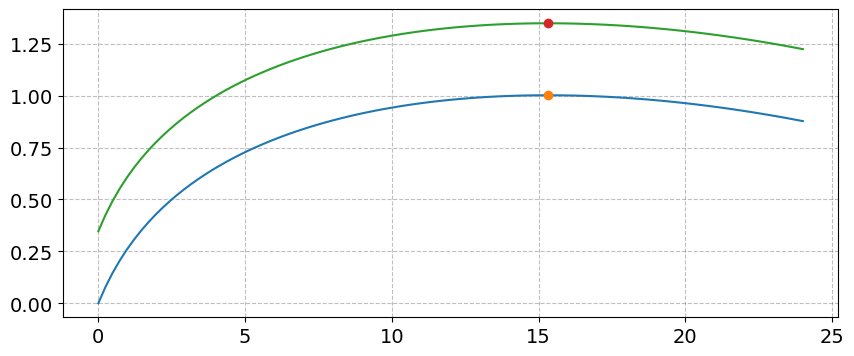

In [36]:
# Optimal level of L is converted to a equation
Optimal_L = sm.Eq(L,sol1)
print('The optimal level of labor supply:')
display(Optimal_L)

# The optimal level of L is substituted into the utility function
utility2 = utility1.subs(Optimal_L.lhs,Optimal_L.rhs)
print('Utility with optimal level of labor:')
display(utility2)

# lambdify function expressions which allows these expressions to be evaulated numerically
Lambda_sol1         = sm.lambdify(args=(alpha,kappa,v,wtilde),expr = sol1)
Lambda_utility1      = sm.lambdify(args=(alpha,kappa,v,G,wtilde,L),expr = utility1)
Lambda_utility2     = sm.lambdify(args=(alpha,kappa,v,G,wtilde),expr = utility2)

# Data to plot labor
L_vec = np.linspace(0,24,100)

Values_optimal_L = Lambda_sol1(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_val)

print('The optimal level of labor supply is:')
print(Values_optimal_L)

vec=[1,2]
for value in vec:
    Utility_vec_value = Lambda_utility1(alpha=alpha_val,kappa=kappa_val,v=v_val,G=value,wtilde=wtilde_val, L=L_vec)
    utility_optimal_L = Lambda_utility2(alpha=alpha_val,kappa=kappa_val,v=v_val,G=value,wtilde=wtilde_val)

    if value == 1:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
    ax.plot(L_vec,Utility_vec_value)

    # Plot the optimal value of labor as a dot
    ax.plot(Values_optimal_L,utility_optimal_L,'o')

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Optimal labor supply i.e., $L^{\star}(\tilde{w})$ is plottet against $w$.

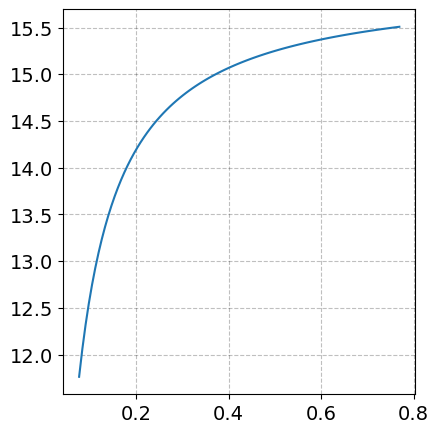

In [47]:
# Vector of possible after tax real wage values
wtilde_vec    = np.linspace(0.1,1,100)
w_vec         = 1 / (1 + tau_val) * wtilde_vec 

# A vector of optimal L is made
Optimal_L_vec = Lambda_sol1(alpha=alpha_val,kappa=kappa_val,v=v_val,wtilde=wtilde_vec)

# The result is plottet
fig           = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(w_vec,Optimal_L_vec)


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**G is plottet against $\tau$**

Eq(G, L*tau*w)

Eq(G, tau*w*(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

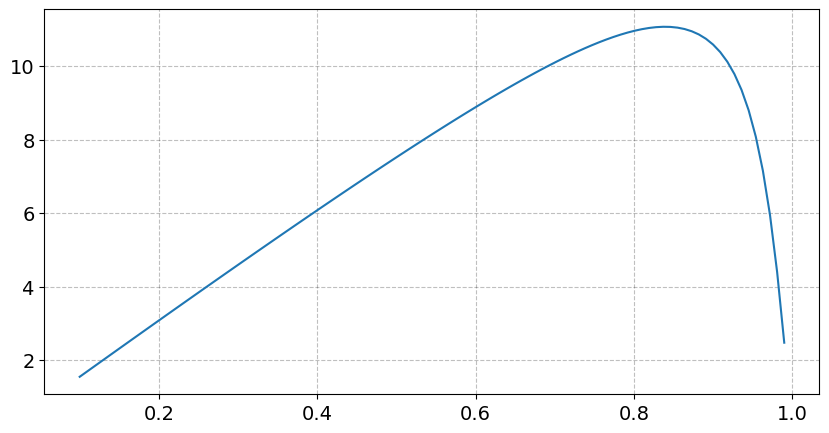

In [58]:
# Government budget is identified
govbudget = sm.Eq(G,tau*w*L)
display(govbudget)

# Optimal labor is substituted into the government budget
govbudget1 = govbudget.subs(L,Lstar.rhs)
display(govbudget1)

# The value of wtilde is substituted into the government budget
govbudget2 = govbudget1.subs(wtilde,(1-tau)*w)
display(govbudget2)

# The government budget function is lambdified
Lambda_govbudget2 = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=govbudget2.rhs)
gov_vec = Lambda_govbudget2(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

# Government budget is plottet against tau
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,gov_vec)

**Implied L is plottet against $\tau$**

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

Eq(L*tau*w, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

Eq(L, (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))

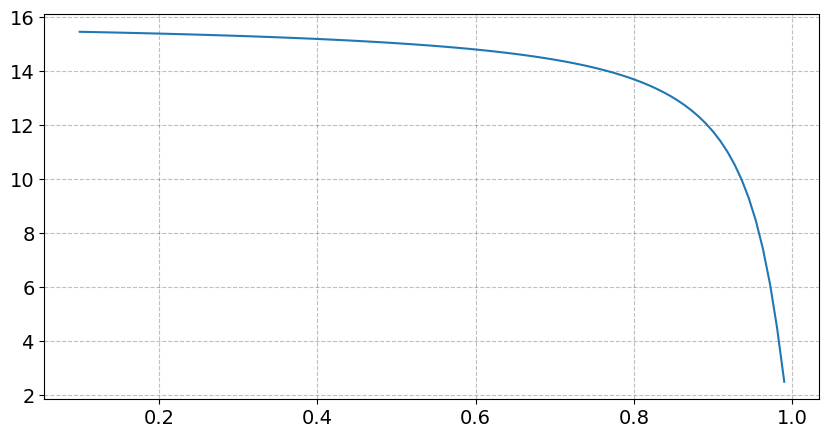

In [66]:
# The value of wtilde in government budget is substituted with (1-tau)*w
govbudget2 = govbudget2.subs(wtilde,(1-tau)*w)
display(govbudget2)

# Government budget is set equal to function value of government budget
Govbudget3 = govbudget2.subs(govbudget.lhs,govbudget.rhs)
display(Govbudget3)

# Implied L is identified
implied_L = sm.solve(Govbudget3,L)
implied_L1= sm.Eq(L,implied_L[0])
display(implied_L1)

# We define a vector of tau values
tau_vec = np.linspace(0.1,0.99,100)

# The function of implied L is lambdified
implied_L_lambdify = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=implied_L[0])
l_vec = implied_L_lambdify(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,l_vec)

**Worker utility is plottet against $\tau$**

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

-L**2*v/2 + log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(L*wtilde + kappa)**alpha)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + wtilde*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + (1 - tau)*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

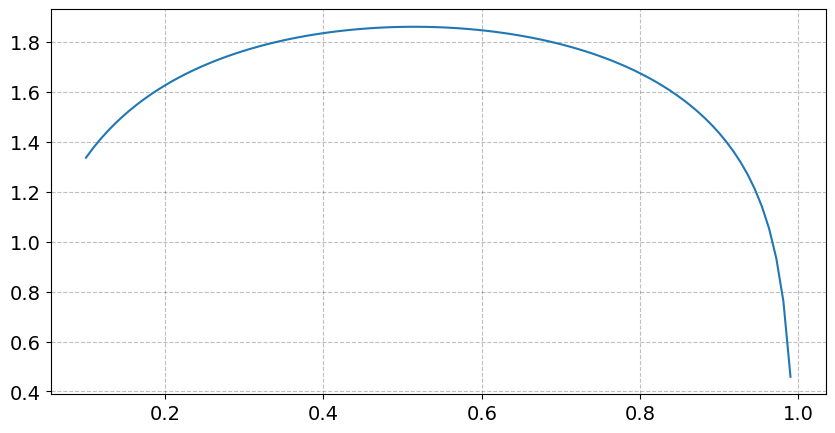

In [73]:
# Utility with budget constraint
display(utility1)
# Substitute utility with budget constraint into government budget
utility_sub1 = utility1.subs(govbudget_sub_subs.lhs,govbudget_sub_subs.rhs)
display(utility_sub1)

# The expression for optimal labor is substituted into the function
utility_sub2 = utility_sub1.subs(implied_L1.lhs,implied_L1.rhs)
display(utility_sub2)

# wtilde is substitued with (1-tau)*w
utility_sub3 = utility_sub2.subs(wtilde,(1-tau)*w)
display(utility_sub3)

# The expression is lambdified
Lambda_utility_sub3 = sm.lambdify(args=(kappa,v,alpha,w,tau),expr=utility_sub3)
utility_vec = Lambda_utility_sub3(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau_vec)

# Worker utility adjusted for G is plotted against tau
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,utility_vec)

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

0.51455078125
1.8591992502006924


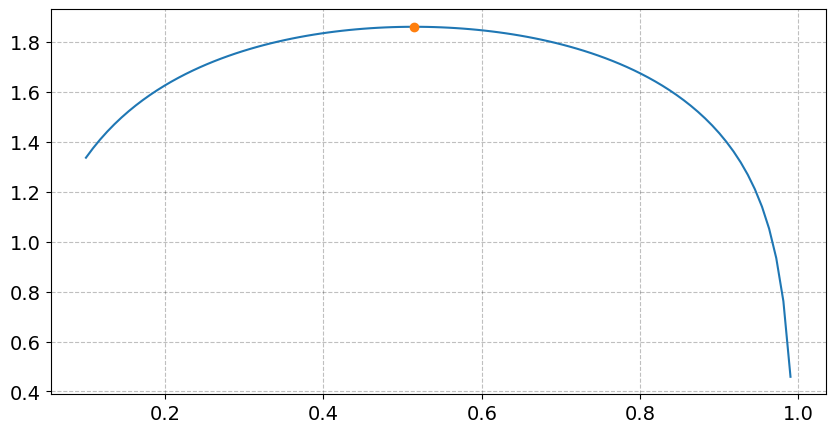

In [74]:
# Define objective function
obj = lambda tau : -utility_subs3_lambdify(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau)

# Define bounds 
bounds=[(0,0.99)]

# Define optimizer
opt = optimize.minimize(obj, 0.5, method='Nelder-Mead', bounds=bounds)
opt_tau = opt.x[0]
print(opt_tau)
print(-opt.fun)

#Plot the result
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,utility_vec)
ax.plot(opt_tau,-opt.fun,'o')

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [86]:
# TEST YOUR MODEL

# TO DO = ADD A PLOT MODULE TO THE MODEL CLASS (EVENTUELT)

from Exam2023 import OptimalTaxationModelClass

model = OptimalTaxationModelClass()

print(model.flag)

tau_star = model.solve_tau()

print(model.flag)

namespace(found_sol_tau=False, found_sol_G=False, found_sol_L=False, found_sol_C=False)
namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)


The more general preference formulation of the worker is formulated in the exam2023.py file. The model is firstly solved where $\sigma = 1.0001$ and $\rho = 1.0001$. This yields a optimal tax rate of 0.5 and a optimal goverment expenditure of 7.51. In comparison, when the model is solved for $\sigma = 1.5$ and $\rho = 1.5$ optimal government tax is unchanged on 0.5 whereas optimal government expenditure decreases to 4.86.  

In [87]:
model = OptimalTaxationModelClass()

tau_star_guess = 0.51455078125

G_star   = model.solve_G(tau_star_guess)

print(model.flag)

tau_vec = np.linspace(model.par.eps,1,100)

G_star_vec_1 = np.empty(100)
L_star_vec_1 = np.empty(100)

for i in range(np.size(tau_vec)):
    G_star_vec_1[i] = model.solve_G(tau_vec[i])
    L_star_vec_1[i] = model.solve_L(tau_vec[i],G_star_vec_1[i])

    if model.flag.found_sol_G == False:
        break

print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal guessed tax rate is: 0.51
Optimal government spending is: 7.71


In [88]:
model = OptimalTaxationModelClass()

model.par.sigma = 1.5
model.par.rho   = 1.5

tau_star_guess = 0.51455078125

G_star   = model.solve_G(tau_star_guess)

print(model.flag)

tau_vec = np.linspace(model.par.eps,1,100)

G_star_vec_2 = np.empty(100)
L_star_vec_2 = np.empty(100)

for i in range(np.size(tau_vec)):
    G_star_vec_2[i] = model.solve_G(tau_vec[i])
    L_star_vec_2[i] = model.solve_L(tau_vec[i],G_star_vec_2[i])

    if model.flag.found_sol_G == False:
        break

print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal guessed tax rate is: 0.51
Optimal government spending is: 4.98


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [89]:
# Param 1
model = OptimalTaxationModelClass()

tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

print(model.flag)

print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

tau_star1 = tau_star
G_star1   = G_star
L_star1   = L_star

namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal tax rate is: 0.51
Optimal government spending is: 7.71
Optimal labor supply is: 14.99
Optimal consumption is: 8.28


In [90]:
# Param 2
model = OptimalTaxationModelClass()

model.par.sigma = 1.5
model.par.rho   = 1.5

tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

print(model.flag)

print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

tau_star2 = tau_star
G_star2   = G_star
L_star2   = L_star

namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)
Optimal tax rate is: 0.46
Optimal government spending is: 4.57
Optimal labor supply is: 9.89
Optimal consumption is: 6.32


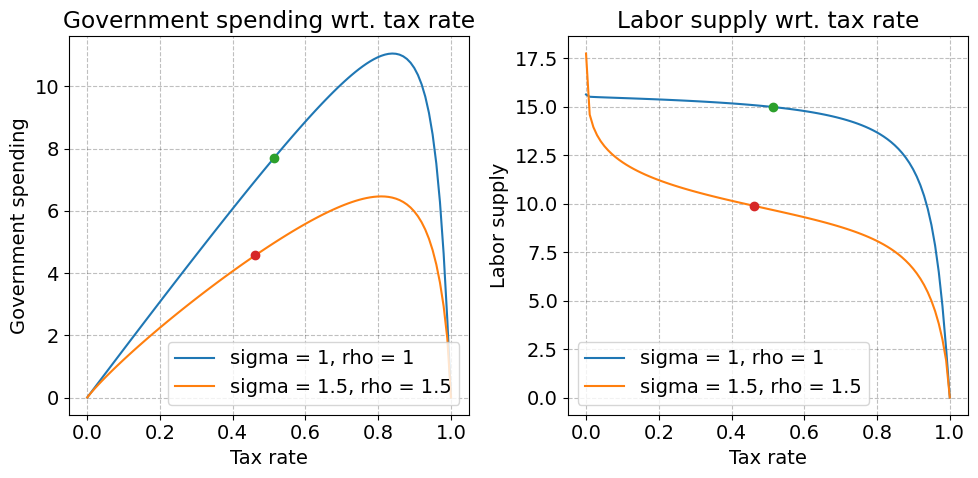

In [83]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)

# Government spending
ax1.set_title('Government spending wrt. tax rate')
ax1.set_xlabel('Tax rate')
ax1.set_ylabel('Government spending')
ax1.plot(tau_vec,G_star_vec_1, label = 'sigma = 1, rho = 1')
ax1.plot(tau_vec,G_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax1.plot(tau_star1,G_star1,'o')
ax1.plot(tau_star2,G_star2,'o')

ax1.legend()

# Labor supply
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Labor supply wrt. tax rate')
ax2.set_xlabel('Tax rate')
ax2.set_ylabel('Labor supply')
ax2.plot(tau_vec,L_star_vec_1, label = 'sigma = 1, rho = 1')
ax2.plot(tau_vec,L_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax2.plot(tau_star1,L_star1,'o')
ax2.plot(tau_star2,L_star2,'o')
ax2.legend()

plt.tight_layout()


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [8]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [9]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [11]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [12]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [14]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [15]:
# write your code here